In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [92]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))


print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [93]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [94]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [95]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [96]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [167]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
        #theta.append(0.01*np.random.standard_normal((dim0, dim1)))
    return theta

In [168]:
def activation(x):
    return 1/(1+np.exp(-x))

In [169]:
def relu_act(x):
    return np.maximum(0.0, x)

In [170]:
def softplus(x):
    return np.log(1+np.exp(x))

In [171]:
def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [172]:
def deriv_relu(x):
    #x[x<=0] = -0.01
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [240]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        if (l != len(theta)-1):
            #print("relu")
            fm.append(softplus(np.dot(fm[l], theta[l])))
        else:
            fm.append(activation(np.dot(fm[l], theta[l])))
            #print("sigmoid output")
    return fm

In [174]:
theta = theta_init([100, 100, 100])
print(theta[3].shape)
cost_total(X_train, theta, train_class_enc, m)
#fm = forward_prop(X_train, theta)

(100, 26)


3.249991648690502

In [175]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [176]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [188]:
epochs = []
train_accuracy = []
valid_accuracy =[]
test_accuracy = []
train_time = []

In [241]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch)
print(theta[0].shape, theta[1].shape, theta[2].shape)

(785, 100) (100, 100) (100, 26)


In [242]:
costs = []
epoch = 1
start = time.time()
#cost_init = cost_total(X_train, theta, train_class_enc, m) #Validation loss not giving much info
cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0]) #Validation loss not giving much info
costs.append(cost_init)
early_stop= 0
while(True):
    count = 0
    #lr = lr0/(np.power(epoch, 1/3))
    #if(lr < 0.001): lr = 0.001
    print("learning rate = ", lr)

    print("Initial Cost on dataset for this epoch {} = {}".format(epoch, cost_init))

    for b in mini_batch:
        X_b = b[0]
        Y_b = b[1]
        fm = forward_prop(X_b, theta)
        delta = [None]*len(fm)

        if (count % 60 == 0):
            print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
        #Backward Propagation

        for l in range(len(fm)-1, 0, -1):
            if (l == len(fm)-1):
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                #print("delta for last layer=",delta[l])
            else:
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_softplus(fm[l])
                #print("delta for hidden layer=",np.mean(delta[l]))

        for t in range(len(theta)):
            theta[t] += lr*np.dot(fm[t].T, delta[t+1])
        
        count+=1
    epoch+=1 #Number of epochs
    #ite+=1

    #cost_final = cost_total(X_train, theta, train_class_enc, m)
    cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
    if(epoch%10==0): costs.append(cost_final)
    print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
    
    if ((cost_final-cost_init) > 0):
        early_stop +=1
    else:
        early_stop=0

    if (early_stop == 30):
        print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
        break

    cost_init = cost_final
    
    
epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer arch= {} are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs = {:2.3f}".format(epochs[-1]))
print("The training time = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

learning rate =  0.1
Initial Cost on dataset for this epoch 1 = 3.2874298171202287
Error on this batch = 3.284603284163933
Error on this batch = 0.48123135185900034
Cost on val dataset after 2 epochs is = 0.4809013226015819
learning rate =  0.1
Initial Cost on dataset for this epoch 2 = 0.4809013226015819
Error on this batch = 0.48087259421483847
Error on this batch = 0.4807502966104766
Cost on val dataset after 3 epochs is = 0.48089268081821873
learning rate =  0.1
Initial Cost on dataset for this epoch 3 = 0.48089268081821873
Error on this batch = 0.4808444325882785
Error on this batch = 0.4807530958211143
Cost on val dataset after 4 epochs is = 0.4808982756932857
learning rate =  0.1
Initial Cost on dataset for this epoch 4 = 0.4808982756932857
Error on this batch = 0.4808460035968181
Error on this batch = 0.4807534252674803
Cost on val dataset after 5 epochs is = 0.4808992589513214
learning rate =  0.1
Initial Cost on dataset for this epoch 5 = 0.4808992589513214
Error on this batc

Error on this batch = 0.48072996480328684
Cost on val dataset after 38 epochs is = 0.4808839119138373
learning rate =  0.1
Initial Cost on dataset for this epoch 38 = 0.4808839119138373
Error on this batch = 0.480819957630614
Error on this batch = 0.4807293628111472
Cost on val dataset after 39 epochs is = 0.48088345151128
learning rate =  0.1
Initial Cost on dataset for this epoch 39 = 0.48088345151128
Error on this batch = 0.48081927004258135
Error on this batch = 0.4807287639727054
Cost on val dataset after 40 epochs is = 0.48088298922106915
learning rate =  0.1
Initial Cost on dataset for this epoch 40 = 0.48088298922106915
Error on this batch = 0.4808185845734299
Error on this batch = 0.48072816796539913
Cost on val dataset after 41 epochs is = 0.480882524792091
learning rate =  0.1
Initial Cost on dataset for this epoch 41 = 0.480882524792091
Error on this batch = 0.48081790086975484
Error on this batch = 0.48072757446713554
Cost on val dataset after 42 epochs is = 0.480882057971

Cost on val dataset after 74 epochs is = 0.4808641236419467
learning rate =  0.1
Initial Cost on dataset for this epoch 74 = 0.4808641236419467
Error on this batch = 0.4807938474452581
Error on this batch = 0.4807071505971682
Cost on val dataset after 75 epochs is = 0.4808634032122756
learning rate =  0.1
Initial Cost on dataset for this epoch 75 = 0.4808634032122756
Error on this batch = 0.4807929863525341
Error on this batch = 0.4807064280395428
Cost on val dataset after 76 epochs is = 0.4808626679143249
learning rate =  0.1
Initial Cost on dataset for this epoch 76 = 0.4808626679143249
Error on this batch = 0.480792111170721
Error on this batch = 0.4807056937367128
Cost on val dataset after 77 epochs is = 0.4808619171418374
learning rate =  0.1
Initial Cost on dataset for this epoch 77 = 0.4808619171418374
Error on this batch = 0.4807912212000953
Error on this batch = 0.4807049470647606
Cost on val dataset after 78 epochs is = 0.4808611502639503
learning rate =  0.1
Initial Cost on 

Cost on val dataset after 110 epochs is = 0.48082225676639795
learning rate =  0.1
Initial Cost on dataset for this epoch 110 = 0.48082225676639795
Error on this batch = 0.4807465816494315
Error on this batch = 0.4806671627310135
Cost on val dataset after 111 epochs is = 0.48082030674782167
learning rate =  0.1
Initial Cost on dataset for this epoch 111 = 0.48082030674782167
Error on this batch = 0.48074443727836114
Error on this batch = 0.4806653270916078
Cost on val dataset after 112 epochs is = 0.48081828496289436
learning rate =  0.1
Initial Cost on dataset for this epoch 112 = 0.48081828496289436
Error on this batch = 0.48074221589372046
Error on this batch = 0.4806634237750605
Cost on val dataset after 113 epochs is = 0.4808161876268204
learning rate =  0.1
Initial Cost on dataset for this epoch 113 = 0.4808161876268204
Error on this batch = 0.48073991336712
Error on this batch = 0.48066144911373726
Cost on val dataset after 114 epochs is = 0.48081401070580865
learning rate =  0.

Error on this batch = 0.4805146870673795
Cost on val dataset after 146 epochs is = 0.48065086662137446
learning rate =  0.1
Initial Cost on dataset for this epoch 146 = 0.48065086662137446
Error on this batch = 0.48056020337120314
Error on this batch = 0.48050451624798113
Cost on val dataset after 147 epochs is = 0.4806394607754862
learning rate =  0.1
Initial Cost on dataset for this epoch 147 = 0.4806394607754862
Error on this batch = 0.48054785655368704
Error on this batch = 0.48049363544788803
Cost on val dataset after 148 epochs is = 0.48062724349948854
learning rate =  0.1
Initial Cost on dataset for this epoch 148 = 0.48062724349948854
Error on this batch = 0.48053463576242544
Error on this batch = 0.48048197717133667
Cost on val dataset after 149 epochs is = 0.48061413583103235
learning rate =  0.1
Initial Cost on dataset for this epoch 149 = 0.48061413583103235
Error on this batch = 0.4805204562453254
Error on this batch = 0.48046946573207666
Cost on val dataset after 150 epoc

Error on this batch = 0.47554601343348496
Cost on val dataset after 182 epochs is = 0.4744353822110586
learning rate =  0.1
Initial Cost on dataset for this epoch 182 = 0.4744353822110586
Error on this batch = 0.47367198404674815
Error on this batch = 0.47430351792394254
Cost on val dataset after 183 epochs is = 0.4728210665106582
learning rate =  0.1
Initial Cost on dataset for this epoch 183 = 0.4728210665106582
Error on this batch = 0.4717724227846554
Error on this batch = 0.47270125088882997
Cost on val dataset after 184 epochs is = 0.47077209601456144
learning rate =  0.1
Initial Cost on dataset for this epoch 184 = 0.47077209601456144
Error on this batch = 0.4692730312982596
Error on this batch = 0.47078244185060913
Cost on val dataset after 185 epochs is = 0.4684046524573115
learning rate =  0.1
Initial Cost on dataset for this epoch 185 = 0.4684046524573115
Error on this batch = 0.4662394196354978
Error on this batch = 0.46878097314061284
Cost on val dataset after 186 epochs is

Error on this batch = 0.40967012386795504
Cost on val dataset after 218 epochs is = 0.40854734706561513
learning rate =  0.1
Initial Cost on dataset for this epoch 218 = 0.40854734706561513
Error on this batch = 0.398045614436102
Error on this batch = 0.408493451393058
Cost on val dataset after 219 epochs is = 0.4073350821734236
learning rate =  0.1
Initial Cost on dataset for this epoch 219 = 0.4073350821734236
Error on this batch = 0.3968772871500808
Error on this batch = 0.40713663694785995
Cost on val dataset after 220 epochs is = 0.4059737538721066
learning rate =  0.1
Initial Cost on dataset for this epoch 220 = 0.4059737538721066
Error on this batch = 0.39559247551909665
Error on this batch = 0.40552862862564754
Cost on val dataset after 221 epochs is = 0.404399729988989
learning rate =  0.1
Initial Cost on dataset for this epoch 221 = 0.404399729988989
Error on this batch = 0.3941442201412687
Error on this batch = 0.40357464197755205
Cost on val dataset after 222 epochs is = 0.

Error on this batch = 0.25968665908903626
Cost on val dataset after 254 epochs is = 0.2729251415069775
learning rate =  0.1
Initial Cost on dataset for this epoch 254 = 0.2729251415069775
Error on this batch = 0.24058747111158282
Error on this batch = 0.25493045008168
Cost on val dataset after 255 epochs is = 0.2681167960920686
learning rate =  0.1
Initial Cost on dataset for this epoch 255 = 0.2681167960920686
Error on this batch = 0.23596761998908075
Error on this batch = 0.250094937746945
Cost on val dataset after 256 epochs is = 0.2633860440425471
learning rate =  0.1
Initial Cost on dataset for this epoch 256 = 0.2633860440425471
Error on this batch = 0.23170618444731086
Error on this batch = 0.24541972516457314
Cost on val dataset after 257 epochs is = 0.25888592117861214
learning rate =  0.1
Initial Cost on dataset for this epoch 257 = 0.25888592117861214
Error on this batch = 0.2278464204078127
Error on this batch = 0.2410438058675193
Cost on val dataset after 258 epochs is = 0

Error on this batch = 0.16304408909095972
Cost on val dataset after 290 epochs is = 0.18235358894332201
learning rate =  0.1
Initial Cost on dataset for this epoch 290 = 0.18235358894332201
Error on this batch = 0.1443818736033289
Error on this batch = 0.1612425490391714
Cost on val dataset after 291 epochs is = 0.18071368120947368
learning rate =  0.1
Initial Cost on dataset for this epoch 291 = 0.18071368120947368
Error on this batch = 0.14255640363659325
Error on this batch = 0.15950088896253029
Cost on val dataset after 292 epochs is = 0.1791398682964693
learning rate =  0.1
Initial Cost on dataset for this epoch 292 = 0.1791398682964693
Error on this batch = 0.14081725488814106
Error on this batch = 0.15781564456033495
Cost on val dataset after 293 epochs is = 0.17763416177451272
learning rate =  0.1
Initial Cost on dataset for this epoch 293 = 0.17763416177451272
Error on this batch = 0.13916624218259693
Error on this batch = 0.1561807250310671
Cost on val dataset after 294 epoch

Error on this batch = 0.11965104510611475
Cost on val dataset after 326 epochs is = 0.14799132961657285
learning rate =  0.1
Initial Cost on dataset for this epoch 326 = 0.14799132961657285
Error on this batch = 0.1155239233589997
Error on this batch = 0.11890916024896765
Cost on val dataset after 327 epochs is = 0.14738124101785618
learning rate =  0.1
Initial Cost on dataset for this epoch 327 = 0.14738124101785618
Error on this batch = 0.1152133481807819
Error on this batch = 0.11818135060934751
Cost on val dataset after 328 epochs is = 0.1467807607797607
learning rate =  0.1
Initial Cost on dataset for this epoch 328 = 0.1467807607797607
Error on this batch = 0.11490715779591301
Error on this batch = 0.11746687646472667
Cost on val dataset after 329 epochs is = 0.14618953260205234
learning rate =  0.1
Initial Cost on dataset for this epoch 329 = 0.14618953260205234
Error on this batch = 0.11460429438870338
Error on this batch = 0.11676497233727882
Cost on val dataset after 330 epoc

Error on this batch = 0.09786253792317372
Cost on val dataset after 362 epochs is = 0.1299742115913566
learning rate =  0.1
Initial Cost on dataset for this epoch 362 = 0.1299742115913566
Error on this batch = 0.1034690877524981
Error on this batch = 0.09738247204277592
Cost on val dataset after 363 epochs is = 0.1295704109121488
learning rate =  0.1
Initial Cost on dataset for this epoch 363 = 0.1295704109121488
Error on this batch = 0.10313243636710259
Error on this batch = 0.09691033308971424
Cost on val dataset after 364 epochs is = 0.12917536340705585
learning rate =  0.1
Initial Cost on dataset for this epoch 364 = 0.12917536340705585
Error on this batch = 0.10280078162366506
Error on this batch = 0.09644675458721721
Cost on val dataset after 365 epochs is = 0.1287888337558967
learning rate =  0.1
Initial Cost on dataset for this epoch 365 = 0.1287888337558967
Error on this batch = 0.10247379440849592
Error on this batch = 0.09599229524394527
Cost on val dataset after 366 epochs 

Error on this batch = 0.08504982320251198
Cost on val dataset after 398 epochs is = 0.11923204287038452
learning rate =  0.1
Initial Cost on dataset for this epoch 398 = 0.11923204287038452
Error on this batch = 0.0924818549592693
Error on this batch = 0.08475769765989295
Cost on val dataset after 399 epochs is = 0.11901504762318707
learning rate =  0.1
Initial Cost on dataset for this epoch 399 = 0.11901504762318707
Error on this batch = 0.09220130833192665
Error on this batch = 0.08446622658517963
Cost on val dataset after 400 epochs is = 0.11880155252460436
learning rate =  0.1
Initial Cost on dataset for this epoch 400 = 0.11880155252460436
Error on this batch = 0.09192254882402841
Error on this batch = 0.08417540405407561
Cost on val dataset after 401 epochs is = 0.11859153300183391
learning rate =  0.1
Initial Cost on dataset for this epoch 401 = 0.11859153300183391
Error on this batch = 0.09164569092529481
Error on this batch = 0.08388525260265624
Cost on val dataset after 402 e

Error on this batch = 0.07557621536101948
Cost on val dataset after 434 epochs is = 0.11317853089337479
learning rate =  0.1
Initial Cost on dataset for this epoch 434 = 0.11317853089337479
Error on this batch = 0.0831761840766216
Error on this batch = 0.07534893528144779
Cost on val dataset after 435 epochs is = 0.11304591427532212
learning rate =  0.1
Initial Cost on dataset for this epoch 435 = 0.11304591427532212
Error on this batch = 0.0829202495338298
Error on this batch = 0.0751225576631805
Cost on val dataset after 436 epochs is = 0.11291455583883955
learning rate =  0.1
Initial Cost on dataset for this epoch 436 = 0.11291455583883955
Error on this batch = 0.08266407839147942
Error on this batch = 0.07489696938085216
Cost on val dataset after 437 epochs is = 0.11278444249793819
learning rate =  0.1
Initial Cost on dataset for this epoch 437 = 0.11278444249793819
Error on this batch = 0.08240767869626187
Error on this batch = 0.07467206186343271
Cost on val dataset after 438 epo

Error on this batch = 0.06743467994649632
Cost on val dataset after 470 epochs is = 0.10925301156193591
learning rate =  0.1
Initial Cost on dataset for this epoch 470 = 0.10925301156193591
Error on this batch = 0.07324452979742548
Error on this batch = 0.06721011071842763
Cost on val dataset after 471 epochs is = 0.10916831426801875
learning rate =  0.1
Initial Cost on dataset for this epoch 471 = 0.10916831426801875
Error on this batch = 0.07287245508171358
Error on this batch = 0.06698616912917085
Cost on val dataset after 472 epochs is = 0.10908444154196141
learning rate =  0.1
Initial Cost on dataset for this epoch 472 = 0.10908444154196141
Error on this batch = 0.07248551427866178
Error on this batch = 0.06676291761587068
Cost on val dataset after 473 epochs is = 0.10900137853942875
learning rate =  0.1
Initial Cost on dataset for this epoch 473 = 0.10900137853942875
Error on this batch = 0.07208390344813478
Error on this batch = 0.06654045119182246
Cost on val dataset after 474 

Error on this batch = 0.06065451621233323
Cost on val dataset after 506 epochs is = 0.10656314761494494
learning rate =  0.1
Initial Cost on dataset for this epoch 506 = 0.10656314761494494
Error on this batch = 0.06303420732522662
Error on this batch = 0.06053306528811001
Cost on val dataset after 507 epochs is = 0.10649033034557615
learning rate =  0.1
Initial Cost on dataset for this epoch 507 = 0.10649033034557615
Error on this batch = 0.06284627496973898
Error on this batch = 0.06041539359037836
Cost on val dataset after 508 epochs is = 0.10641816868510548
learning rate =  0.1
Initial Cost on dataset for this epoch 508 = 0.10641816868510548
Error on this batch = 0.0626593183104276
Error on this batch = 0.06030115210123945
Cost on val dataset after 509 epochs is = 0.10634679339988162
learning rate =  0.1
Initial Cost on dataset for this epoch 509 = 0.10634679339988162
Error on this batch = 0.06247314493294129
Error on this batch = 0.06018994853106652
Cost on val dataset after 510 e

Error on this batch = 0.056676205400405716
Cost on val dataset after 542 epochs is = 0.10446416044758922
learning rate =  0.1
Initial Cost on dataset for this epoch 542 = 0.10446416044758922
Error on this batch = 0.05641126902240899
Error on this batch = 0.056544225875607035
Cost on val dataset after 543 epochs is = 0.10441280798562182
learning rate =  0.1
Initial Cost on dataset for this epoch 543 = 0.10441280798562182
Error on this batch = 0.05623326181878922
Error on this batch = 0.056410775202846104
Cost on val dataset after 544 epochs is = 0.10436167641640891
learning rate =  0.1
Initial Cost on dataset for this epoch 544 = 0.10436167641640891
Error on this batch = 0.05605552512610961
Error on this batch = 0.05627589587264134
Cost on val dataset after 545 epochs is = 0.10431083410198722
learning rate =  0.1
Initial Cost on dataset for this epoch 545 = 0.10431083410198722
Error on this batch = 0.05587786599839897
Error on this batch = 0.05613962006165395
Cost on val dataset after 5

Error on this batch = 0.051671504793547714
Cost on val dataset after 578 epochs is = 0.10307250880749844
learning rate =  0.1
Initial Cost on dataset for this epoch 578 = 0.10307250880749844
Error on this batch = 0.04997240219831117
Error on this batch = 0.05153338003828829
Cost on val dataset after 579 epochs is = 0.10304880538266328
learning rate =  0.1
Initial Cost on dataset for this epoch 579 = 0.10304880538266328
Error on this batch = 0.049820510111396786
Error on this batch = 0.05139508903274805
Cost on val dataset after 580 epochs is = 0.10302533232710058
learning rate =  0.1
Initial Cost on dataset for this epoch 580 = 0.10302533232710058
Error on this batch = 0.04967074897556934
Error on this batch = 0.05125662346702148
Cost on val dataset after 581 epochs is = 0.1030019230717397
learning rate =  0.1
Initial Cost on dataset for this epoch 581 = 0.1030019230717397
Error on this batch = 0.04952277147290775
Error on this batch = 0.051117947364231496
Cost on val dataset after 582

Error on this batch = 0.04543243274463604
Cost on val dataset after 614 epochs is = 0.10217500685160537
learning rate =  0.1
Initial Cost on dataset for this epoch 614 = 0.10217500685160537
Error on this batch = 0.045073559102793745
Error on this batch = 0.045226179143708356
Cost on val dataset after 615 epochs is = 0.10215859320602226
learning rate =  0.1
Initial Cost on dataset for this epoch 615 = 0.10215859320602226
Error on this batch = 0.04495700443350589
Error on this batch = 0.045022186835516835
Cost on val dataset after 616 epochs is = 0.1021433767491498
learning rate =  0.1
Initial Cost on dataset for this epoch 616 = 0.1021433767491498
Error on this batch = 0.04484184633917579
Error on this batch = 0.04482054321118966
Cost on val dataset after 617 epochs is = 0.10212942636001103
learning rate =  0.1
Initial Cost on dataset for this epoch 617 = 0.10212942636001103
Error on this batch = 0.044728066545055414
Error on this batch = 0.04462125459964579
Cost on val dataset after 61

Error on this batch = 0.039244250493201335
Cost on val dataset after 650 epochs is = 0.10180208638620815
learning rate =  0.1
Initial Cost on dataset for this epoch 650 = 0.10180208638620815
Error on this batch = 0.040579694513556044
Error on this batch = 0.03913252594264789
Cost on val dataset after 651 epochs is = 0.10177891957779639
learning rate =  0.1
Initial Cost on dataset for this epoch 651 = 0.10177891957779639
Error on this batch = 0.04042938078568473
Error on this batch = 0.03902385797068099
Cost on val dataset after 652 epochs is = 0.10175644903988322
learning rate =  0.1
Initial Cost on dataset for this epoch 652 = 0.10175644903988322
Error on this batch = 0.040278597263740876
Error on this batch = 0.03891799680714512
Cost on val dataset after 653 epochs is = 0.1017346387195975
learning rate =  0.1
Initial Cost on dataset for this epoch 653 = 0.1017346387195975
Error on this batch = 0.04012715012956084
Error on this batch = 0.03881472030156297
Cost on val dataset after 654

Error on this batch = 0.03640671887301742
Cost on val dataset after 686 epochs is = 0.10105183649997598
learning rate =  0.1
Initial Cost on dataset for this epoch 686 = 0.10105183649997598
Error on this batch = 0.03510675928271737
Error on this batch = 0.036340275153265766
Cost on val dataset after 687 epochs is = 0.10102868665246616
learning rate =  0.1
Initial Cost on dataset for this epoch 687 = 0.10102868665246616
Error on this batch = 0.034990926691659985
Error on this batch = 0.03627303264034481
Cost on val dataset after 688 epochs is = 0.10100590184921442
learning rate =  0.1
Initial Cost on dataset for this epoch 688 = 0.10100590184921442
Error on this batch = 0.03487847929535871
Error on this batch = 0.036204913842188075
Cost on val dataset after 689 epochs is = 0.10098345322386172
learning rate =  0.1
Initial Cost on dataset for this epoch 689 = 0.10098345322386172
Error on this batch = 0.03476932743533987
Error on this batch = 0.0361358466905221
Cost on val dataset after 69

Error on this batch = 0.033439094637717236
Cost on val dataset after 722 epochs is = 0.10047380580104895
learning rate =  0.1
Initial Cost on dataset for this epoch 722 = 0.10047380580104895
Error on this batch = 0.03200593536576696
Error on this batch = 0.033348117639778706
Cost on val dataset after 723 epochs is = 0.1004522871826898
learning rate =  0.1
Initial Cost on dataset for this epoch 723 = 0.1004522871826898
Error on this batch = 0.03190562905685948
Error on this batch = 0.033258533785543234
Cost on val dataset after 724 epochs is = 0.10043197282256003
learning rate =  0.1
Initial Cost on dataset for this epoch 724 = 0.10043197282256003
Error on this batch = 0.03180570862628583
Error on this batch = 0.033170296804108206
Cost on val dataset after 725 epochs is = 0.10041289494678775
learning rate =  0.1
Initial Cost on dataset for this epoch 725 = 0.10041289494678775
Error on this batch = 0.03170626701079371
Error on this batch = 0.03308338057530572
Cost on val dataset after 72

Error on this batch = 0.03100538941533312
Cost on val dataset after 758 epochs is = 0.10030359272797518
learning rate =  0.1
Initial Cost on dataset for this epoch 758 = 0.10030359272797518
Error on this batch = 0.028523942093920916
Error on this batch = 0.03095458770682824
Cost on val dataset after 759 epochs is = 0.1003009016685972
learning rate =  0.1
Initial Cost on dataset for this epoch 759 = 0.1003009016685972
Error on this batch = 0.028415901410017215
Error on this batch = 0.03090440351171403
Cost on val dataset after 760 epochs is = 0.10029688980521925
learning rate =  0.1
Initial Cost on dataset for this epoch 760 = 0.10029688980521925
Error on this batch = 0.02830700742388567
Error on this batch = 0.030854748547580524
Cost on val dataset after 761 epochs is = 0.10029168349209959
learning rate =  0.1
Initial Cost on dataset for this epoch 761 = 0.10029168349209959
Error on this batch = 0.02819751610060294
Error on this batch = 0.03080553661116753
Cost on val dataset after 762

Error on this batch = 0.02945620865478092
Cost on val dataset after 794 epochs is = 0.0999300070324682
learning rate =  0.1
Initial Cost on dataset for this epoch 794 = 0.0999300070324682
Error on this batch = 0.025350739192325996
Error on this batch = 0.0294173676253326
Cost on val dataset after 795 epochs is = 0.0999169436855777
learning rate =  0.1
Initial Cost on dataset for this epoch 795 = 0.0999169436855777
Error on this batch = 0.02529468883552512
Error on this batch = 0.029379308283229124
Cost on val dataset after 796 epochs is = 0.09990379048234388
learning rate =  0.1
Initial Cost on dataset for this epoch 796 = 0.09990379048234388
Error on this batch = 0.025239742755136886
Error on this batch = 0.02934214313361438
Cost on val dataset after 797 epochs is = 0.09989056739625007
learning rate =  0.1
Initial Cost on dataset for this epoch 797 = 0.09989056739625007
Error on this batch = 0.02518581371854445
Error on this batch = 0.029305949896904417
Cost on val dataset after 798 e

Error on this batch = 0.028647075011275867
Cost on val dataset after 830 epochs is = 0.0998209520309446
learning rate =  0.1
Initial Cost on dataset for this epoch 830 = 0.0998209520309446
Error on this batch = 0.024109667725141195
Error on this batch = 0.02861992537778595
Cost on val dataset after 831 epochs is = 0.0997734025910375
learning rate =  0.1
Initial Cost on dataset for this epoch 831 = 0.0997734025910375
Error on this batch = 0.024068267651109726
Error on this batch = 0.028589948713502875
Cost on val dataset after 832 epochs is = 0.09972851032957125
learning rate =  0.1
Initial Cost on dataset for this epoch 832 = 0.09972851032957125
Error on this batch = 0.02403048141251201
Error on this batch = 0.028558006741519155
Cost on val dataset after 833 epochs is = 0.09968728610717863
learning rate =  0.1
Initial Cost on dataset for this epoch 833 = 0.09968728610717863
Error on this batch = 0.02399625651319296
Error on this batch = 0.028524866387466475
Cost on val dataset after 83

Error on this batch = 0.02783472104962134
Cost on val dataset after 866 epochs is = 0.09938092436154508
learning rate =  0.1
Initial Cost on dataset for this epoch 866 = 0.09938092436154508
Error on this batch = 0.023241720422960827
Error on this batch = 0.027815292808882033
Cost on val dataset after 867 epochs is = 0.09938669797320089
learning rate =  0.1
Initial Cost on dataset for this epoch 867 = 0.09938669797320089
Error on this batch = 0.02321764159831612
Error on this batch = 0.027795467688465032
Cost on val dataset after 868 epochs is = 0.09939229409354373
learning rate =  0.1
Initial Cost on dataset for this epoch 868 = 0.09939229409354373
Error on this batch = 0.023193958454683763
Error on this batch = 0.027775426655313632
Cost on val dataset after 869 epochs is = 0.0993976814517575
learning rate =  0.1
Initial Cost on dataset for this epoch 869 = 0.0993976814517575
Error on this batch = 0.02317067780541632
Error on this batch = 0.027755318933160945
Cost on val dataset after 

Cost on val dataset after 901 epochs is = 0.0981338919279311
learning rate =  0.03
Initial Cost on dataset for this epoch 901 = 0.0981338919279311
Error on this batch = 0.02285866588825353
Error on this batch = 0.02748271199655562
Cost on val dataset after 902 epochs is = 0.09813864563128856
learning rate =  0.03
Initial Cost on dataset for this epoch 902 = 0.09813864563128856
Error on this batch = 0.022851212549740013
Error on this batch = 0.02747947235768673
Cost on val dataset after 903 epochs is = 0.0981432320508299
learning rate =  0.03
Initial Cost on dataset for this epoch 903 = 0.0981432320508299
Error on this batch = 0.022843915113099404
Error on this batch = 0.02747635945353835
Cost on val dataset after 904 epochs is = 0.09814766500656581
learning rate =  0.03
Initial Cost on dataset for this epoch 904 = 0.09814766500656581
Error on this batch = 0.02283676330203348
Error on this batch = 0.027473365603198276
Cost on val dataset after 905 epochs is = 0.09815195704525458
learnin

In [234]:
calc_accuracy(X_test, theta, test_actual_class_enc)

14.876923076923077

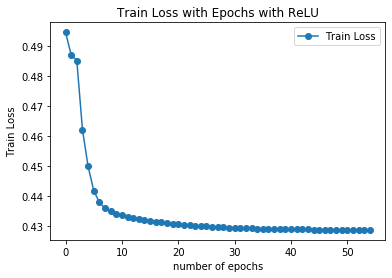

In [237]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Train Loss with Epochs with ReLU")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("relu_trainloss.png", dpi=1000, bbox_inches='tight')
plt.show()

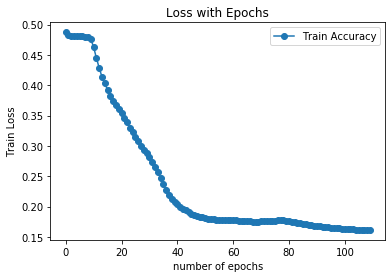

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()